# Primal-Dual Interior-Point for Quadratic Optimization

In [1]:
%matplotlib inline
import numpy as np
import cvxpy as cp
from scipy.linalg import hilbert
from scipy.sparse import diags
from matplotlib import pyplot as plt

## Writing the objective and constraint function, gradient, and hessian for objective

In [2]:
def h(x, q, P):
    return np.dot(P, x) - q

def f(x, A, b):
    return np.dot(x, np.dot(A, x)) / 2 - np.dot(b, x)

def f_grad(x, A, b):
    return np.dot(A, x) - b

def f_hessian(x, A, b):
    return A

## Defining functions for primal-dual interior-point method

In [3]:
def H_pd(x, A, b, P, q, u):
    n = len(x)
    res = f_hessian(x, A, b)
    for i in range(n):
        res += u[i] * np.matmul(P[i].T, P[i]) / (q[i]-np.dot(P[i],x))**2
    return res

In [4]:
def residual(x, A, b, P, u, t):
    n = len(x)
    r_dual = np.dot(A, x) - b + np.dot(P.T, u)
    r_cent = -np.dot(np.diag(u), h(x, q, P)) - np.ones(n)/t
    return np.concatenate((r_dual, r_cent))

In [5]:
def get_delta_y(x, A, b, P, q, u, t):
    H = H_pd(x, A, b, P, q, u)
    Dh = P
    B = np.concatenate((H, -np.dot(np.diag(u), Dh)), axis = 0)
    C = np.concatenate((Dh.T, -np.diag(h(x, q, P))), axis = 0)
    M = np.concatenate((B, C), axis = 1)
    r = residual(x, A, b, P, u, t)
    delta_y = np.dot(np.linalg.inv(M), -r)
    return delta_y, r

## Find starting point using **CVXPY**

In [6]:
def find_feasible(q, P):
    n = len(q)
    x = cp.Variable((n))
    s = cp.Variable((1))

    constraints = [cp.max(P @ x - q) <= s, s <= 0]
    obj = cp.Maximize(s)
    prob = cp.Problem(obj, constraints)
    prob.solve()
    return x.value

## Backtracking line search function

In [7]:
def backtrack(x, u, delta_x, delta_u, r, A, b, P, q, alpha, beta, t):
    indices = np.where(delta_u < 0)
    s = np.inf
    if len(indices[0]) > 0:
        s = np.min(-u[indices] / delta_u[indices])
    s = 0.99 * np.minimum(1, s)
    
    while True:
        new_x = x + s * delta_x
        if (h(new_x, q, P) < 0).all():
            break
        s *= beta
    
    while True: 
        new_x = x + s * delta_x
        new_u = u + s * delta_u
        new_r = residual(new_x, A, b, P, new_u, t)
        if np.linalg.norm(new_r) <= (1 - alpha*s) * np.linalg.norm(r):
            break
        s *= beta
    
    return s

## Defining primal-dual interior-point method

In [8]:
def PD_interior_point(x, u, A, b, q, P, beta, alpha, mu, eps):
    gaps, r_feas, iters = [], [], []
    i = 0
    n = len(x)
    eta = -np.dot(h(P,q,x).T, u)
    
    while True:
        t = mu * n / eta
        
        delta_y, r = get_delta_y(x, A, b, P, q, u, t)
        delta_x, delta_u = delta_y[:n], delta_y[n:]
        s = backtrack(x, u, delta_x, delta_u, r, A, b, P, q, alpha, beta, t)
        x += s * delta_x
        u += s * delta_u
        
        eta = -np.dot(h(P,q,x).T, u)
        r_norm = np.linalg.norm(r[:n])
        
        i += 1
        iters.append(i)
        gaps.append(eta)
        r_feas.append(r_norm)
        
        if eta < eps and r_norm < eps:
            break
    
    return iters, gaps, r_feas

## Constants

In [9]:
beta = 0.5
alpha = 0.01
eps = 1e-6
mu = 10
sizes = [100, 400]

## Initialization function

In [10]:
def init(n):
    P = np.random.normal(size = (n, n))
    q = np.random.normal(size = n)
    u = np.random.uniform(0.1, 1, n)
    b = np.ones(n)
    return P, q, b, u

## Experiments on tridiagonal matrices: tridiag(-1, 4, -1)

In [11]:
def get_tridiag(n):
    return init(n), diags([-1, 4, -1], [-1, 0, 1], shape=(n, n)).toarray()

In [13]:
for n in sizes:
    (P, q, b, u), A = get_tridiag(n)
    x = find_feasible(q, P)
    
    # plt.style.use('seaborn-whitegrid')
    plt.figure(figsize=(9, 6))
    plt.title("Surrogate duality gap and r_feas for tridiagonal matrix with size {} * {}".format(n, n))
    plt.xlabel("Primal-dual interior-point iterations")
    plt.ylabel("Errors")
    iters, gaps, r_feas = PD_interior_point(x, u, A, b, q, P, beta, alpha, mu, eps)
    plt.plot(iters, gaps, label='surrogate duality gap')
    plt.plot(iters, r_feas, label='r_feas')
        
    plt.yscale('log')
    plt.legend()
    plt.show()

## Experiments on Hilbert matrices

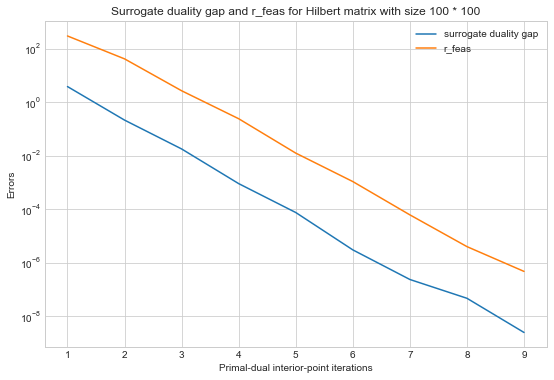

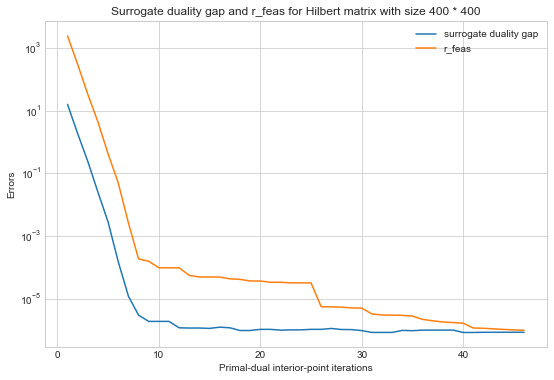

In [ ]:
for n in sizes:
    A = hilbert(n)
    P, q, b, u = init(n)
    x = find_feasible(q, P)
    
    plt.style.use('seaborn-whitegrid')
    plt.figure(figsize=(9, 6))
    plt.title("Surrogate duality gap and r_feas for Hilbert matrix with size {} * {}".format(n, n))
    plt.xlabel("Primal-dual interior-point iterations")
    plt.ylabel("Errors")
    iters, gaps, r_feas = PD_interior_point(x, u, A, b, q, P, beta, alpha, mu, eps)
    plt.plot(iters, gaps, label='surrogate duality gap')
    plt.plot(iters, r_feas, label='r_feas')
        
    plt.yscale('log')
    plt.legend()
    plt.show()